# Downloading the data and preprocessing it.

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Mon May  5 15:16:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 30.67 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Function to read all lines from a file
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [ ]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 342 ms, sys: 75.1 ms, total: 417 ms
Wall time: 414 ms


(180040, 30212, 30135)

In [ ]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# Getting the sentences and characters
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

# TokenBert training helpers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import numpy as np
import os

In [ ]:
# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
num_classes = len(label_encoder.classes_)
BATCH_SIZE = 32
EPOCHS = 5
LR = 2e-5

In [ ]:
# === Dataset ===
class PubMedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True,
                                  max_length=self.max_len, return_tensors="pt")
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# === Model ===
class TokenBERTClassifier(nn.Module):
    def __init__(self, bert_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.bert.config.hidden_size, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        x = torch.relu(self.fc(x))
        x = self.dropout(x)
        return self.out(x)

In [ ]:
# === Callback: EarlyStopping ===
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# === Train & Evaluate ===
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# Evaluation helpers

In [ ]:
from torch.nn.functional import softmax
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import itertools

In [ ]:
def predict(model, dataloader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    return (
        torch.cat(all_preds).numpy(),
        torch.cat(all_probs).numpy(),
        torch.cat(all_labels).numpy()
    )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def evaluate_classification(y_true, y_pred, class_names, figsize=(10, 8), text_size=14, norm=True):
    """
    Plots the confusion matrix with annotation and prints classification report.

    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - class_names: List of class names (ordered)
    - figsize: Tuple, figure size
    - text_size: Font size of the annotations
    - norm: Whether to show normalized percentages
    """
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=class_names,
           yticklabels=class_names)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(n_classes), range(n_classes)):
        value = cm[i, j]
        percent = cm_norm[i, j] * 100
        if norm:
            cell_text = f"{value}\n({percent:.1f}%)"
        else:
            cell_text = f"{value}"
        ax.text(j, i, cell_text,
                ha="center", va="center",
                color="white" if value > threshold else "black",
                fontsize=text_size)

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_results(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    return {
        "accuracy": acc * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100
    }

# Training & Evaluation Pipeline

In [ ]:
# === Prepare Data ===
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

train_texts = train_sentences
val_texts = val_sentences
train_labels = train_labels_encoded
val_labels = val_labels_encoded

train_dataset = PubMedDataset(train_texts, train_labels, tokenizer)
val_dataset = PubMedDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [ ]:
model = TokenBERTClassifier(bert_model_name, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-7, verbose=True)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=3, min_delta=0.5)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
best_val_loss = float('inf')
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
os.makedirs("best_weights", exist_ok=True)
# === Training Loop ===
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_weights/checkpoint_tokenbert.pt")
        print("✅ Saved best model!")

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered!")
        break

    # Save training history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)


Epoch 1/5


Training:   0%|          | 0/5627 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/945 [00:00<?, ?it/s]

Train Loss: 0.3951, Val Loss: 0.3137, Val Acc: 0.8850
✅ Saved best model!

Epoch 2/5


Training:   0%|          | 0/5627 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/945 [00:00<?, ?it/s]

Train Loss: 0.3074, Val Loss: 0.3163, Val Acc: 0.8854

Epoch 3/5


Training:   0%|          | 0/5627 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/945 [00:00<?, ?it/s]

Train Loss: 0.2519, Val Loss: 0.3377, Val Acc: 0.8825

Epoch 4/5


Training:   0%|          | 0/5627 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/945 [00:00<?, ?it/s]

Train Loss: 0.2007, Val Loss: 0.3908, Val Acc: 0.8810
⏹️ Early stopping triggered!


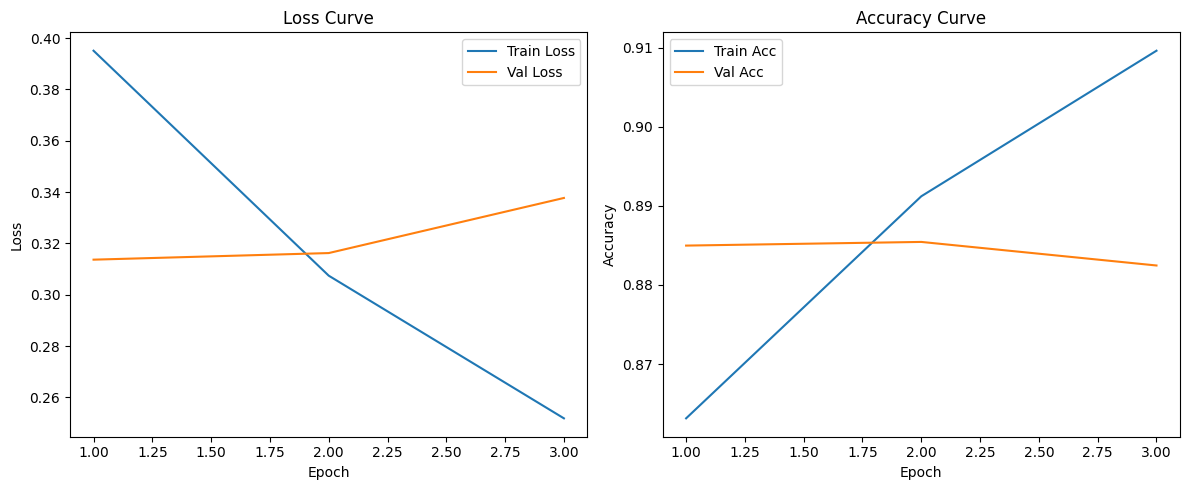

In [ ]:
import matplotlib.pyplot as plt
# === Plot Training Curve ===
epochs_range = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
import shutil
import os

# 目标备份文件夹
backup_folder = '/content/drive/My Drive/ColabBackup'
os.makedirs(backup_folder, exist_ok=True)

# 复制模型权重文件
src = './best_weights/checkpoint_tokenbert.pt'
dst = os.path.join(backup_folder, 'checkpoint_tokenbert.pt')
shutil.copy(src, dst)

'/content/drive/My Drive/ColabBackup/checkpoint_tokenbert.pt'

In [58]:
# ==========Load Model===============
loaded_model = TokenBERTClassifier(bert_model_name, num_classes).to(device)
checkpoint_path = backup_folder + '/checkpoint_tokenbert.pt'
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [59]:
from torchinfo import summary

summary(loaded_model, input_data={
    'input_ids': torch.randint(0, 100, (1, 128)).to(device),
    'attention_mask': torch.ones(1, 128).to(device)
})

Layer (type:depth-idx)                                       Output Shape              Param #
TokenBERTClassifier                                          [1, 5]                    --
├─BertModel: 1-1                                             [1, 768]                  --
│    └─BertEmbeddings: 2-1                                   [1, 128, 768]             --
│    │    └─Embedding: 3-1                                   [1, 128, 768]             23,440,896
│    │    └─Embedding: 3-2                                   [1, 128, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 128, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [1, 128, 768]             1,536
│    │    └─Dropout: 3-5                                     [1, 128, 768]             --
│    └─BertEncoder: 2-2                                      [1, 128, 768]             --
│    │    └─ModuleList: 3-6                                  --             

In [60]:
# Prepare test data
test_texts = test_sentences
test_labels = test_labels_encoded
test_dataset = PubMedDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Predicting:   0%|          | 0/942 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.82      0.75      3621
 CONCLUSIONS       0.87      0.84      0.85      4571
     METHODS       0.92      0.96      0.94      9897
   OBJECTIVE       0.79      0.52      0.63      2333
     RESULTS       0.93      0.92      0.93      9713

    accuracy                           0.88     30135
   macro avg       0.84      0.81      0.82     30135
weighted avg       0.88      0.88      0.88     30135



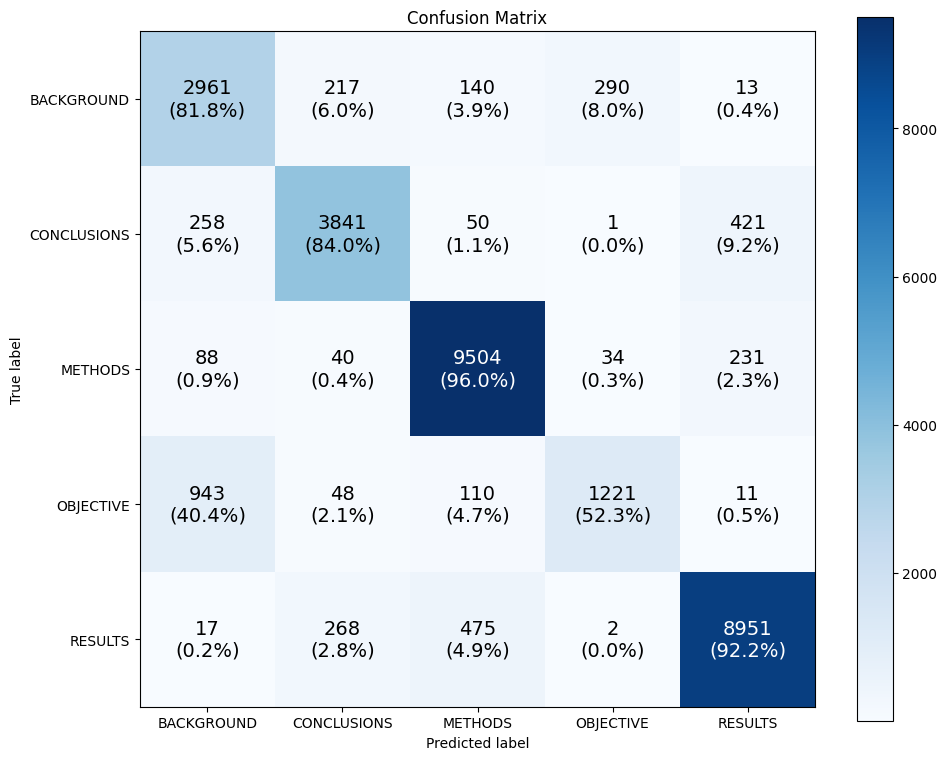

 Tokenbert test performance:
{'accuracy': 87.86460925833748, 'precision': 87.9783614706306, 'recall': 87.86460925833748, 'f1': 87.63712870712749}


In [61]:
# Run prediction and evaluation on test set
test_preds, test_probs, test_true = predict(loaded_model, test_loader)
evaluate_classification(test_true, test_preds, class_names=label_encoder.classes_)
results = calculate_results(test_true, test_preds)
print(" Tokenbert test performance:")
print(results)

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import zscore
import itertools

def plot_transition_matrix_with_zscore(df, class_names, zscore_center=True, figsize=(8, 6), cmap="coolwarm"):
    """
    Build and plot a z-score normalized transition matrix.
    Args:
        df: DataFrame containing 'target' and 'line_number'
        class_names: ordered list of target class names
        zscore_center: if True, center values around 0 with z-score
    """
    n_classes = len(class_names)
    label2idx = {label: idx for idx, label in enumerate(class_names)}
    transition_counts = np.zeros((n_classes, n_classes))

    # === Group lines by abstract ===
    abstracts = []
    current = []

    for _, row in df.iterrows():
        if row['line_number'] == 0 and current:
            abstracts.append(current)
            current = []
        current.append(row['target'])
    if current:
        abstracts.append(current)

    # === Count label transitions ===
    for abstract in abstracts:
        for i in range(len(abstract) - 1):
            from_idx = label2idx[abstract[i]]
            to_idx = label2idx[abstract[i + 1]]
            transition_counts[from_idx][to_idx] += 1

    # === Normalize to probabilities (row-wise) ===
    with np.errstate(divide='ignore', invalid='ignore'):
        transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
        transition_probs = np.nan_to_num(transition_probs)

    # === Apply z-score normalization if needed ===
    if zscore_center:
        flat_zscore = zscore(transition_probs.flatten())
        transition_probs = flat_zscore.reshape(n_classes, n_classes)

    # === Plot ===
    plt.figure(figsize=figsize)
    sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap=cmap,
                xticklabels=class_names,
                yticklabels=class_names,
                center=0 if zscore_center else None)

    plt.xlabel("Next Label")
    plt.ylabel("Current Label")
    plt.title("Z-score Normalized Label Transition Matrix")
    plt.tight_layout()
    plt.show()

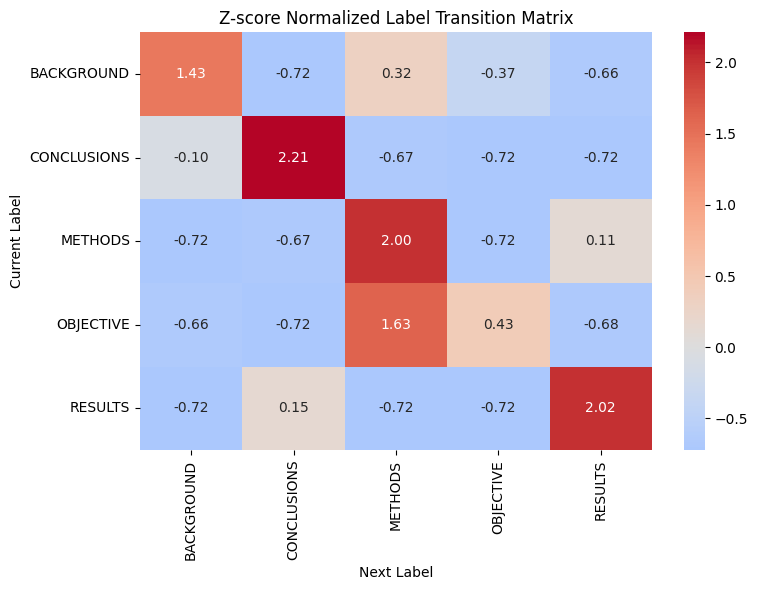

In [75]:
plot_transition_matrix_with_zscore(train_df, class_names=label_encoder.classes_)